In [1]:
calname='et_cal29'
import glob
import rhessys.utilities as rut
import hydro.objective_fxns as ofx
import ProgressBar as pb
import ipyparallel as par

In [2]:
c = par.Client()

In [3]:
c.ids

[0, 1, 2, 3, 4, 5, 6, 7]

In [4]:
view = c.load_balanced_view()

In [5]:
VCM = pd.read_pickle('./data/VCM.pcl')

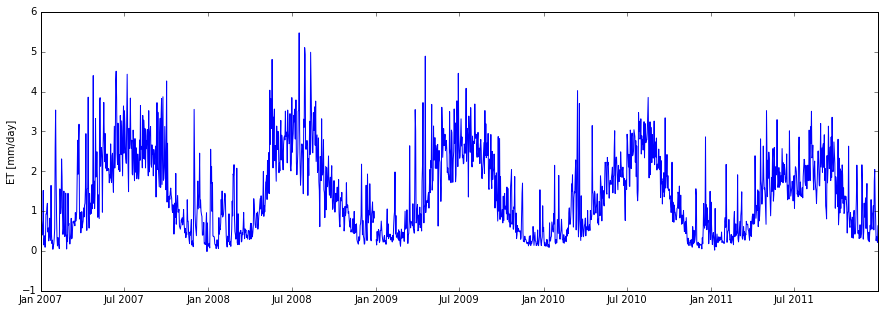

In [6]:
plt.figure(figsize=(15,5))
plt.plot(VCM.index, VCM.ET)
plt.ylabel('ET [mm/day]')

In [7]:
files = glob.glob('/RHESSys/jemez/out/%s/%s_*basin.daily'%(calname,calname))

In [8]:
tmp = rut.readRHESSysBasin('/RHESSys/jemez/out/%s/%s_0_basin.daily'%(calname,calname))
datmin = tmp.index.min()
datmax = VCM.index.max()

In [9]:
print VCM.index.max()
print VCM.index.min()

2011-12-31 00:00:00
2007-01-01 00:00:00


In [10]:
print tmp.index.min()
print tmp.index.max()

2006-10-01 00:00:00
2012-10-01 00:00:00


In [11]:
%%px
calname='et_cal29'
import rhessys.utilities as rut
import hydro.objective_fxns as ofx
dat = pd.read_pickle('/Volumes/Users/Theo/projects/RHESSys/jemez/data/VCM.pcl') # load ET in mm

wys = [2010,2011,2012]

tmp = rut.readRHESSysBasin('/RHESSys/jemez/out/%s/%s_0_basin.daily'%(calname,calname))
#datmin = tmp.index.min()
#datmax = dat.index.max()

datmin = '2007-01-01'
datmax = '2011-12-31'

#print datmin
#print datmax
dat = dat.loc[datmin:datmax]

#dat.loc[:'2008-1-15'] = np.NaN
#dat.loc['2008-06-15':'2009-1-15'] = np.NaN
#dat.loc['2009-06-15':'2010-1-15'] = np.NaN
#dat.loc['2010-06-15':'2011-1-15'] = np.NaN
#dat.loc['2011-06-15':'2011-12-31'] = np.NaN

#3dat.dropna(inplace=True)

dat2 = dat.resample('W',how='mean')

In [12]:
def compute_ns(fl):
    idx = int(fl.split('_')[-2])
    tmp = rut.readRHESSysBasin(fl).loc[datmin:datmax] # load the data
    
    # mask everything but the melt season and a little after
    #tmp.loc[:'2008-1-15'] = np.NaN
    #tmp.loc['2008-06-15':'2009-1-15'] = np.NaN
    #tmp.loc['2009-06-15':'2010-1-15'] = np.NaN
    #tmp.loc['2010-06-15':'2011-1-15'] = np.NaN
    #tmp.loc['2011-06-15':'2011-12-31'] = np.NaN

    #tmp.dropna(inplace=True)

    tmp2 = tmp.resample('W',how='mean')
    
    nashsut = round(ofx.nashsut(dat.ET,tmp.ET),4)
    pbias = round(ofx.wy_percent_bias(dat.ET,tmp.ET),4)
    pe = round(ofx.percenterror(dat.ET,tmp.ET),4)
    
    nashsut2 = round(ofx.nashsut(dat2.ET,tmp2.ET),4)
    pbias2 = round(ofx.wy_percent_bias(dat2.ET,tmp2.ET),4)
    pe2 = round(ofx.percenterror(dat2.ET,tmp2.ET),4)
    
    return idx,nashsut,pbias,pe,nashsut2,pbias2,pe2

In [13]:
res = view.map(compute_ns,files)

In [14]:
p = pb.ProgressBar(len(files))

In [15]:
import time

In [16]:
while res.ready() == False:
    p.animate_ipython(res.progress)
    time.sleep(2)

[****************100%******************]  19944 of 20000 complete


In [17]:
res.ready()

True

In [18]:
idx,nse,pbias,pe,nse2,pbias2,pe2 = zip(*res.result)

In [19]:
#gw1 = np.loadtxt('/RHESSys/jemez/scripts/%s_gw1.txt'%calname)
#gw2 = np.loadtxt('/RHESSys/jemez/scripts/%s_gw2.txt'%calname)
#ksat = np.loadtxt('/RHESSys/jemez/scripts/%s_ksat.txt'%calname)
#m = np.loadtxt('/RHESSys/jemez/scripts/%s_m.txt'%calname)
rd = np.loadtxt('/RHESSys/jemez/scripts/%s_rd.txt'%calname)
#sd = np.loadtxt('/RHESSys/jemez/scripts/%s_sd.txt'%calname)
gs = np.loadtxt('/RHESSys/jemez/scripts/%s_gs.txt'%calname)
#p_surf = np.loadtxt('/RHESSys/jemez/scripts/%s_p0.txt'%calname)
#pdecay = np.loadtxt('/RHESSys/jemez/scripts/%s_pdecay.txt'%calname)

In [20]:
df = pd.DataFrame({'rd':rd,'gs':gs, \
'idx':np.arange(0,len(files))})

#df = pd.DataFrame({'gw1':gw1,'gw2':gw2,'ksat':ksat,'m':m,'rd':rd,'gs':gs,'p0':p_surf,'pdecay':pdecay,
#                   'idx':np.arange(0,50000)})
tmpdf = pd.DataFrame({'nse':nse,'pbias':pbias,'pe':pe,'nse_weekly':nse2,'pbias_weekly':pbias2,'pe_weekly':pe2,'idx':idx})

In [21]:
df = pd.merge(df,tmpdf,on='idx')

In [22]:
df2 = df.loc[df.pbias_weekly==df.pbias_weekly.min()]

In [23]:
def metric_weekly(df):
    bias = 1.-(df.pe_weekly/100.)
    nse = df.nse_weekly

    
    return np.nanmean([bias,nse])

In [24]:
df['weekly_metric'] = df.apply(metric_weekly,axis=1)

In [25]:
df.loc[df.rd > 10] = np.NaN
df.dropna(inplace=True)

In [26]:
df2 = df.loc[df.weekly_metric==df.weekly_metric.max()]

In [27]:
df.loc[df.nse_weekly==df.nse_weekly.max()]

,gs,idx,rd,nse,nse_weekly,pbias,pbias_weekly,pe,pe_weekly,weekly_metric
8984,0.007,8984,0.011,-1.2936,-0.9265,0.3687,0.3657,0.9503,0.6949,0.033276


In [28]:
df.loc[df.pbias==df.pbias.min()]

,gs,idx,rd,nse,nse_weekly,pbias,pbias_weekly,pe,pe_weekly,weekly_metric
16005,0.0064,16005,0.108,-2.305,-1.016,0.1023,0.1207,1.1129,0.7543,-0.011771


In [29]:
df2

,gs,idx,rd,nse,nse_weekly,pbias,pbias_weekly,pe,pe_weekly,weekly_metric
8984,0.007,8984,0.011,-1.2936,-0.9265,0.3687,0.3657,0.9503,0.6949,0.033276


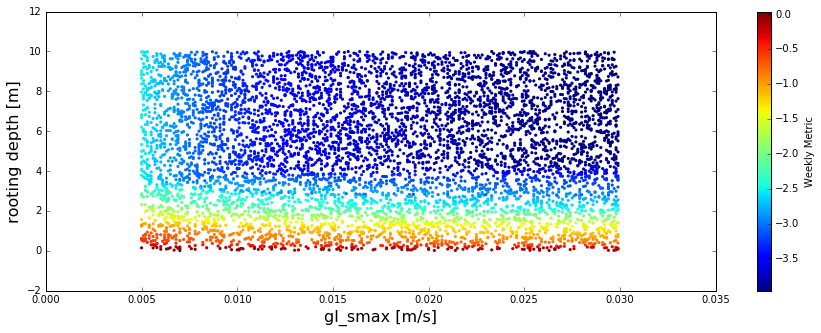

In [30]:
plt.figure(figsize=(15,5))
plt.scatter(df.gs,df.rd,s=10,c=df.weekly_metric,edgecolors='none')
plt.colorbar(label = 'Weekly Metric')
plt.xlabel('gl_smax [m/s]', fontsize=16)
plt.ylabel('rooting depth [m]', fontsize=16);

In [31]:
df['sd'] = 10

In [32]:
VCM = VCM[datmin:datmax]

In [33]:
VCM2 = VCM.resample('W',how='mean')

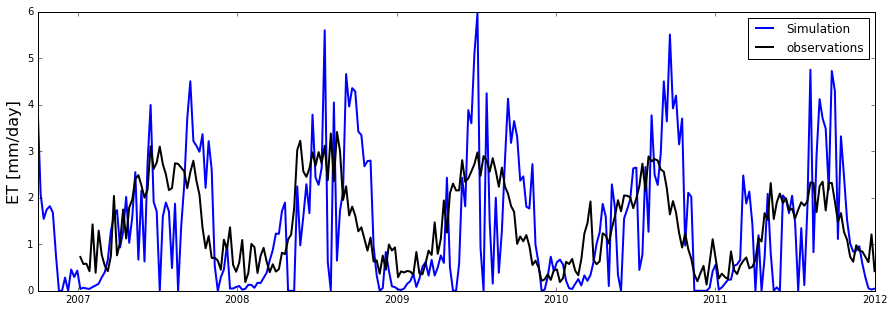

In [34]:
#idx = df2.index[ct]
idx= 16005
tmp = rut.readRHESSysBasin('/RHESSys/jemez/out/%s/%s_%s_basin.daily'%(calname,calname,idx)).loc[datmin:datmax]

#tmp.loc[:'2008-1-15'] = np.NaN
#tmp.loc['2008-06-01':'2009-1-15'] = np.NaN
#tmp.loc['2009-06-01':'2010-1-15'] = np.NaN
#tmp.loc['2010-06-15':'2011-1-15'] = np.NaN
#tmp.loc['2011-06-15':'2011-12-31'] = np.NaN

tmp2 = tmp.resample('W', how='mean')
plt.figure(figsize=(15,5))
plt.plot(tmp2.index,tmp2.ET,'-b',label='Simulation',lw=2)
plt.plot(VCM2.index,VCM2.ET,'-k',label='observations',lw=2)
plt.legend(loc='upper right')
plt.ylabel('ET [mm/day]', fontsize=16)
#plt.title('ET CAL10 2937: metric: 0.51', fontsize=16)
#plt.savefig('./figures/et_cal_07_best_weekly.png')
#ct += 1

In [42]:
VCM.to_csv('./VCM_flux_tower.csv',index_label='date')

In [37]:
from rpy2.robjects.packages import importr
# import R's "base" package
base = importr('base')

# import R's "utils" package
utils = importr('utils')

OSError: [Errno 2] No such file or directory